In [71]:
import pandas as pd
import numpy as np
import datetime
import statsmodels.tsa.api as tsa
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import STL
from pandas.plotting import register_matplotlib_converters
from scipy.stats import boxcox
import warnings
warnings.filterwarnings('ignore')

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

from statsmodels.tsa.arima_model import ARMA, ARIMA
import statsmodels.api as sm

%matplotlib inline

In [58]:
def get_data(coin = 'bitcoin', year = 2017):
    
    df = pd.read_csv(f'./data/{coin}_{year}.csv')
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit = 's')
    df.set_index('timestamp', inplace = True)
    df.sort_index(inplace = True)
    df = df[['Count','Open','High','Low','Close','Volume','VWAP','Target']]
    
    return df

In [59]:
btc2017 = get_data()
btc2018 = get_data('bitcoin', 2018)
btc2019 = get_data('bitcoin', 2019)
btc2020 = get_data('bitcoin', 2020)
btc2021 = get_data('bitcoin', 2021)

In [60]:
btc = pd.concat([btc2017, btc2018, btc2019, btc2020, btc2021], axis = 0)

In [8]:
def resample(df, time_period = '1D'):
    df = df.resample(time_period).first()
    return df

In [92]:
def add_cols(df, momentum = 7, volatility = 30, sma = 50):
    
    df['diff'] = df['Close'] - df['Close'].shift(1)
    df['log_close'] = np.log(df['Close'])
    df['log_diff'] = df['log_close'] - df['log_close'].shift(1)
    df['log_return'] = df['log_close']/(df['log_close'].shift(1))
    df['direction'] = np.where(df['log_return'] > 0, 1, 0)
    df['momentum'] = df['log_return'].rolling(momentum).mean().shift(1)
    df['volatility'] = df['log_return'].rolling(volatility).std().shift(1)
    df['sma_7'] = df['Close'].rolling(7).mean()
    df['sma_50'] = df['Close'].rolling(50).mean()
    df['sma_200'] = df['Close'].rolling(200).mean()
    sma_distance = f'sma_{sma}'
    df[sma_distance] = (df['Close'] - df['Close'].rolling(sma).mean()).shift(1)
    df['log_sqrt_close'] = np.sqrt(df['log_close'])
    
    df = df[df['Close'].notna()]
    
    return df

In [93]:
daily = resample(btc)
weekly = resample(btc, '1W')
monthly = resample(btc, '1M')

In [94]:
daily = add_cols(daily)
weekly = add_cols(weekly, momentum = 1, volatility = 4, sma = 7)

In [12]:
p_log_sqrt_close = adfuller(daily['log_sqrt_close'])[1]
p_log_sqrt_close

p2 = adfuller(daily['Close'])[1]
p2

p3 = adfuller(daily['log_diff'].dropna())
p3

p4 = adfuller(daily['log_return'].dropna())
p4

p5 = adfuller(daily['log_close'])
p5

(-0.7092902944889851,
 0.8443284440283875,
 2,
 1574,
 {'1%': -3.434511370146751,
  '5%': -2.8633779962665122,
  '10%': -2.567748516280279},
 -5273.191332114597)

In [13]:
def create_lags(df, col = 'log_close', lags = 7):
    
    for i in range(1, lags+1):
        col_name = f'lag_{i}'
        df[col_name] = df['log_close'].shift(i)
    df.dropna(inplace = True)
        
    return df

In [14]:
adf_tests = []
fit = Holt(daily['log_close'].dropna(), exponential = False).fit(use_brute = True)
a = fit.fittedvalues
adfuller(a)

(-0.7228758168961888,
 0.8407348775316157,
 2,
 1574,
 {'1%': -3.434511370146751,
  '5%': -2.8633779962665122,
  '10%': -2.567748516280279},
 -5454.266950754698)

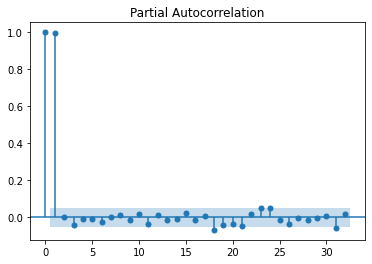

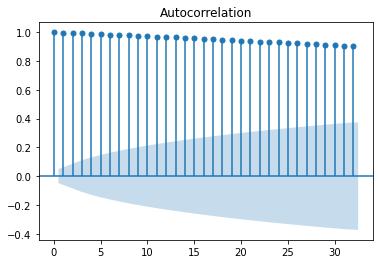

In [15]:
plot_pacf(a);
plot_acf(a);

In [16]:
def simple_moving_average(df, windows = [7,50,200]):
    for i in windows:
        col = f'sma_{i}'
        df[col] = df['Close'].rolling(i, min_periods = int(i*.75)).mean()
        df[col].plot(figsize = (40,10), legend = True, subplots = False)
    
    df['Close'].plot(legend = True);
    return df

In [17]:
def decomposition_plot(df):
        '''Takes time series dataframe and decompose it in order to observe trend, seasonality, and residuals'''
        decomposition = tsa.seasonal_decompose(df, period = 1, model = 'multiplicative', freq = 7)
        trend = decomposition.trend
        seasonal = decomposition.seasonal
        residual = decomposition.resid
        plt.figure(figsize=(10,7))
        plt.subplot(511)
        plt.plot(ts, label='Original', color='red')
        plt.legend(loc='best')
        plt.subplot(512)
        plt.plot(trend, label='Trend', color='blue')
        plt.legend(loc='best')
        plt.subplot(513)
        plt.plot(seasonal,label='Seasonality', color='orange')
        plt.legend(loc='best')
        plt.subplot(514)
        plt.plot(residual, label='Residuals', color='black')
        plt.legend(loc='best')
        plt.tight_layout()

In [47]:
### Seasonal Decomposition
def seasonal_decomposition(df):
    periods = [1,3,7,30,50,365]
    model = ['multiplicative', 'additive']

    combinations = []
    for x in periods:
        for y in model:
            combinations.append((x,y))
    
    adfullercombinations = []

    for i in combinations:
        components = tsa.seasonal_decompose(df, period = i[0], model = i[1])
        trend = components.trend
        seasonal = components.seasonal
        residual = components.resid
        observed = components.observed
        x = adfuller(residual.dropna())
        if x[1] < .05:
            adfullercombinations.append([i,x])
    
    return adfullercombinations

In [66]:
combs = best_combinations(daily['Close'])

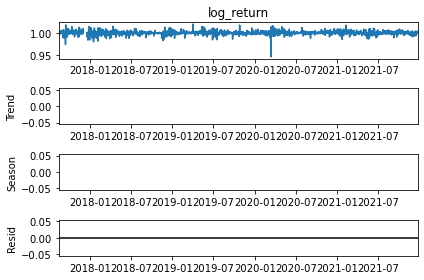

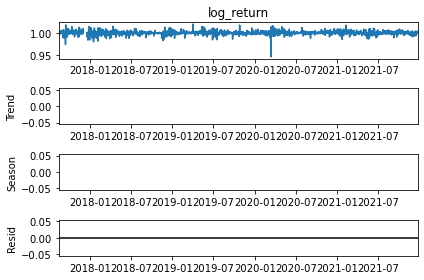

In [95]:
res = STL(daily['log_return'], period = 3, seasonal_deg = 0, robust = True).fit()
res.plot()

In [97]:
x, _ = boxcox(daily['log_return'].dropna())
adfuller(x)

(-27.499172984220415,
 0.0,
 1,
 1573,
 {'1%': -3.4345140199818918,
  '5%': -2.8633791658322503,
  '10%': -2.567749139071643},
 -12384.634455776197)

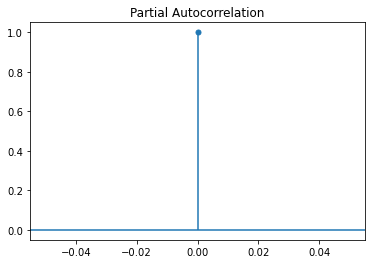

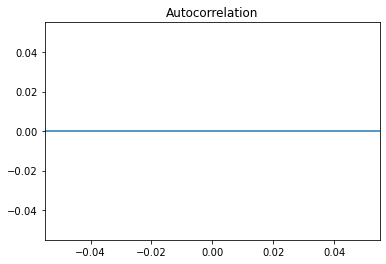

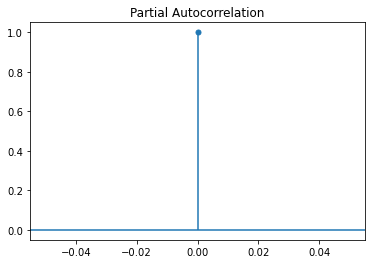

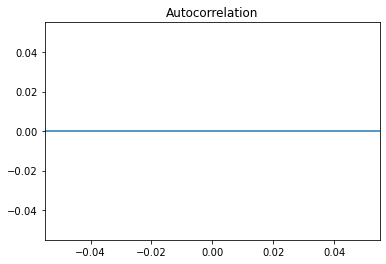

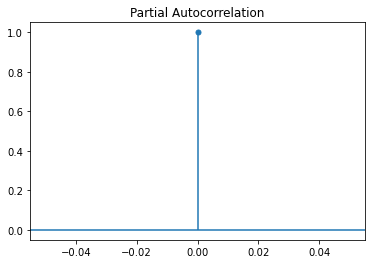

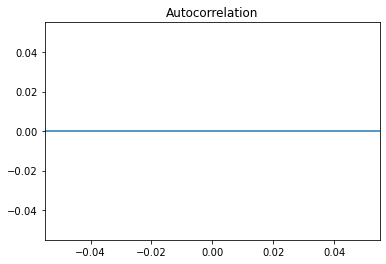

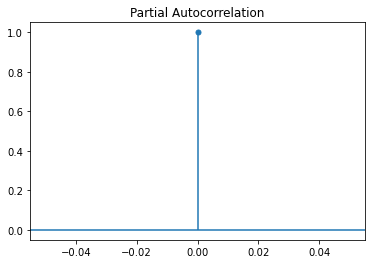

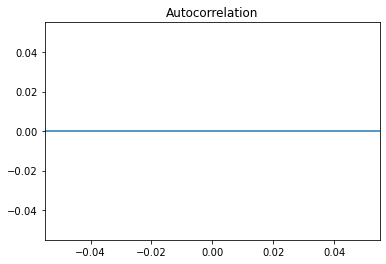

In [98]:
plot_pacf(daily['log_return'],lags = 50);
plot_acf(daily['log_return'], lags = 50);

plot_pacf(daily['log_return']);
plot_acf(daily['log_return']);

plot_pacf(daily['log_diff']);
plot_acf(daily['log_diff']);

plot_pacf(daily['log_return'], lags = 50);
plot_acf(daily['log_return'], lags = 50);

In [22]:
mod_arma = ARMA(a, order=(1,0))

In [23]:
res_arma = mod_arma.fit()

In [24]:
print(res_arma.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1577
Model:                     ARMA(1, 0)   Log Likelihood                2770.382
Method:                       css-mle   S.D. of innovations              0.042
Date:                Tue, 04 Jan 2022   AIC                          -5534.765
Time:                        00:08:36   BIC                          -5518.675
Sample:                             0   HQIC                         -5528.786
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.4796      0.785     12.077      0.000       7.941      11.018
ar.L1.y        0.9992      0.001   1152.883      0.000       0.997       1.001
                                    Roots           

In [25]:
mod2_arma = ARMA(a, order=(0,1))
res2_arma = mod2_arma.fit()
print(res2_arma.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1577
Model:                     ARMA(0, 1)   Log Likelihood                -915.321
Method:                       css-mle   S.D. of innovations              0.432
Date:                Tue, 04 Jan 2022   AIC                           1836.643
Time:                        00:08:37   BIC                           1852.732
Sample:                             0   HQIC                          1842.622
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.3625      0.021    437.319      0.000       9.321       9.405
ma.L1.y        0.9688      0.005    198.079      0.000       0.959       0.978
                                    Roots           

In [99]:
#p: The number of lag observations included in the model, also called the lag order.
#d: The number of times that the raw observations are differenced, also called the degree of differencing.
#q: The size of the moving average window, also called the order of moving average.

In [101]:
model = ARIMA(x, order=(0,1,1))
model2 = model.fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 1574
Model:                 ARIMA(0, 1, 1)   Log Likelihood                6279.364
Method:                       css-mle   S.D. of innovations              0.004
Date:                Tue, 04 Jan 2022   AIC                         -12552.728
Time:                        10:17:47   BIC                         -12536.644
Sample:                             1   HQIC                        -12546.751
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.337e-08   2.48e-07      0.337      0.736   -4.02e-07    5.69e-07
ma.L1.D.y     -1.0000      0.002   -480.883      0.000      -1.004      -0.996
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [121]:
r = daily[['log_return','volatility', 'momentum']].dropna()
print(r.notnull().sum())
x = r['log_return']
y = r['volatility']
z = r['momentum']

log_return    1515
volatility    1515
momentum      1515
dtype: int64


In [138]:
model = ARIMA(x, order =(1,0,1))
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             log_return   No. Observations:                 1515
Model:                     ARMA(1, 1)   Log Likelihood                6073.626
Method:                       css-mle   S.D. of innovations              0.004
Date:                Tue, 04 Jan 2022   AIC                         -12139.253
Time:                        10:37:25   BIC                         -12117.960
Sample:                             0   HQIC                        -12131.325
                                                                              
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.0002      0.000   9279.020      0.000       1.000       1.000
ar.L1.log_return    -0.6302      0.179     -3.529      0.000      -0.980      -0.280
ma.L1.log_return     0.5572      0.191      2.918      0.004       0.183       0.932
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.5867           +0.0000j            1.5867            0.5000
MA.1           -1.7947           +0.0000j            1.7947            0.5000
-----------------------------------------------------------------------------
"""

In [141]:
x = list(range(11))

TypeError: can only concatenate list (not "int") to list